<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/5_multimodality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多峰性関数の最適化

これまでにほとんど議論せずに来たが，CMA-ESでは共分散行列の学習率，進化パスの累積率，ステップサイズの減衰率など，アルゴリズム中に現れるハイパーパラメータの全てに推奨値が設けられている．これは，最適化問題の次元数および１イテレーションに生成する解の個数$\lambda$（集団サイズ）から計算されるようになっている．また，集団サイズについても，推奨値が$\lambda = 3 + \lfloor 4 \log(N) \rfloor$と定められている．そのため，問題毎に明らかに適切な値が異なる初期分布パラメータ（初期平均ベクトルや初期ステップサイズ）以外は特に気にせずに利用することができる．加えて，単峰な関数であれば，初期分布パラメータの影響自体も比較的小さいため，よほど不適切な値出ない限りは効率的に探索可能である．

しかし，目的関数が多峰性関数である場合，

* 集団サイズ
* 初期分布パラメータ

の両者が得られる局所解に大きく影響する．また，一度の探索で望ましい解が得られることは稀であるから，

* リスタート戦略

が非常に重要となる．

ここでは，多峰性関数における集団サイズや初期分布パラメータの影響と，リスタート戦略について学ぶ．

## 代表的な多峰性関数

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Rastrigin 関数

Rastrigin関数は，
$$
f(x) = \sum_{i=1}^{N} x_i^2 + 10 (1 - \cos(2\pi x_i))
$$
と定義され，各座標がおおよそ整数値の位置において局所解が存在する．
探索領域は$[-5, 5]^N$などと定義される場合が多い．大域的最適解は$x^* = 0$である．Rastrigin関数は局所解を多数持つ一方で，巨視的にみれば第一項の影響で下凸な関数であるように見える．このような景観を持つ関数を「大域的単峰な関数」もしくは「大谷構造をもつ関数」などと呼ぶ．

In [4]:
def rastrigin(x):
    a = 10
    return np.sum(x ** 2 + a * (1 - np.cos(2 * np.pi * x)))

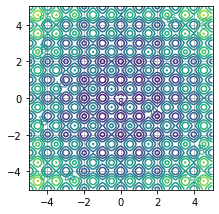

In [5]:
dx, dy = 0.1, 0.1
y, x = np.mgrid[slice(-5, 5 + dy, dy), slice(-5, 5 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = rastrigin(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 10)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()

#### Bohachevsky 関数

Bohachevsky 関数も大域的単峰な関数の代表的なものであり，
$$
f(x) = \sum_{i=1}^{N-1} x_i^2 + 2 x_{i+1}^2 + 0.3 (1 - \cos(3 \pi x_i)) + 0.4 (1 - \cos(4 \pi x_{i+1}))
$$
と定義される．探索領域は$[-15, 15]^N$などと定義される場合が多く，最適解は$x^* = 0$である．

In [6]:
def bohachevsky(x):
    """bohachevsky function [-15, 15] or [1, 15]"""
    uni = np.sum(x[:-1] ** 2 + 2 * x[1:] ** 2)
    multi = np.sum(0.3 * (1 - np.cos(3 * np.pi * x[:-1])) + 0.4 * (1 - np.cos(4 * np.pi * x[1:])))
    return uni + multi

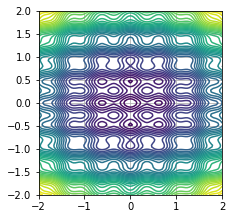

In [7]:
dx, dy = 0.04, 0.04
y, x = np.mgrid[slice(-2, 2 + dy, dy), slice(-2, 2 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = bohachevsky(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 50)
plt.grid()

#### Skew Rastrigin 関数

Skew Rastrigin は上記のRastrigin関数$f_\text{rastrigin}$を用いて
$$
f(x) = f_\text{rastrigin}(\tilde{x}) \quad \text{where} \quad \tilde{x} = \begin{cases}x & x \leq 0 \\ 10 x & x > 0\end{cases}
$$
と定義される関数である．定義域はRastrigin関数と同様，$[-5, 5]^{N}$である．大域的に下凸に見えるという観点では大域的単峰といえるが，最適解$x^* = 0$を中心に目的関数の感度が大きく変わるような関数である．最適解の近傍に目的関数が急激に大きくなるような領域が存在することから，最適解周辺が有望でないとみなされやすく，「騙し構造を持つ関数」などと呼ばれる．最適解が制約の境界付近に存在する場合，制約対処法次第では通常のRastrigin関数であってもSkew-Rastrigin関数のように最適化法からは見える場合がある．

最適解を発見することは非常に難しい関数であり，筆者の知る限り，この関数（$N > 5$程度）の最適解を高い確率で求めることができる合理的なアルゴリズムは存在しない．

In [24]:
def skewrastrigin(x):
    y = x.copy()
    y[y > 0] *= 10
    return rastrigin(y)

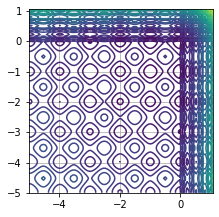

In [25]:
dx, dy = 0.06, 0.06
y, x = np.mgrid[slice(-5, 1 + dy, dy), slice(-5, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = skewrastrigin(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 30)
plt.grid()

## Double-Sphere 関数
Double-Sphere関数は名前の通り，二つのSphere関数の最小値を取る関数であり，
$$
f(x) = \min\left[ \sum_{i=1}^{N} (x_i - a_i)^2, N + s \sum_{i=1}^{N} (x_i - b_i)^2\right]
$$
と定義される．定義域は$[-10, 10]^N$などとされる場合が多い．この関数は，局所解を二つしか持たないものの，最適解の谷（minの１つ目の要素）の方が小さな値となる領域が限定的であるため（$s < 1$と設定），初期分布によっては最適解の発見が困難になる問題である．このような問題は，「UV構造を持つ関数」（間口の広い局所解の谷と間口の狭い最適解の谷を持つ関数）などと呼ばれる．

In [22]:
def doublesphere(x):
    s = 0.2
    a = 2.5
    b = - np.sqrt((a**2 - 1) / s)
    f1 = np.sum((x - a)**2)
    f2 = len(x) + s * np.sum((x - b)**2)
    return np.fmin(f1, f2)

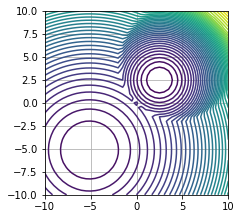

In [23]:
dx, dy = 0.5, 0.5
y, x = np.mgrid[slice(-10, 10 + dy, dy), slice(-10, 10 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = doublesphere(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 50)
plt.grid()

#### Schwefel 関数

Schwefel 関数は，大域的多報な関数の代表的な関数であり，
$$
f(x) = \sum_{i=1}^{N} 418.9829 - x_i \sin(\sqrt{|x_i|})
$$
と定義される．定義域は$[-500, 500]^N$である．最適解は$x^* = (420.9687, \dots, 420.9687)$であり，そのときの目的関数値は$0$である．Rastrigin関数と異なり，原点付近では凹凸の振幅が小さく，原点から離れるほどに凹凸の振幅が大きくなるような関数である．

In [29]:
def schwefel(x):
    a = 418.9829
    pen = np.sum(np.fmax(np.abs(x) - 500, 0)**2)
    if pen > 0:
        fx = 1000 + pen  # 便宜上，定義域の外側は大きな値とする
    else:
        fx = np.sum(a - x * np.sin(np.sqrt(np.abs(x))))
    return fx

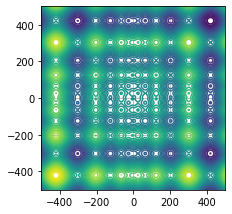

In [28]:
dx, dy = 5, 5
y, x = np.mgrid[slice(-500, 500 + dy, dy), slice(-500, 500 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = schwefel(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 50)
plt.grid()

## 数値実験

In [37]:
class CMAES(object):
    """CMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        
        self.D = np.ones(self.N) # 共分散行列の固有値
        self.B = np.eye(self.N)  # 共分散行列の固有ベクトル
        self.C = np.dot(self.B * self.D, self.B.T) # 共分散行列
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.mueff = 1.0 / np.sum(self.weights**2)
        self.cs = (2 + self.mueff) / (3 + self.mueff + self.N)
        self.ds = 1.0 + self.cs + max(1.0, np.sqrt(self.mueff / self.N))
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        
        # For CMA
        self.cmu = self.mueff / (self.N ** 2 / 2 + self.N + self.mueff)

        # For Checker
        self.t = 0
        self.neval = 0
        
    def sample(self):
        """候補解を生成する．"""
        self.arz = np.random.normal(size=self.arx.shape)
        self.ary = np.dot(np.dot(self.arz, self.B) * np.sqrt(self.D), self.B.T)
        self.arx = self.mean + self.sigma * self.ary
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
            self.neval += 1
        
    def update_param(self):
        """パラメータを更新する．"""
        self.t += 1
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, self.arz[idx])
        # 共分散行列の更新
        self.C = (1 - self.cmu) * self.C + self.cmu * np.dot(self.ary[idx].T * self.weights, self.ary[idx])
        # 共分散行列の固有値分解
        self.D, self.B = np.linalg.eigh(self.C)

        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, self.arx[idx] - self.mean)

    @property
    def coordinate_std(self):
        return np.sqrt(np.diag(self.C)) * self.sigma

    @property
    def lam(self):
        return len(self.arf)

    @property
    def xmean(self):
        return self.mean

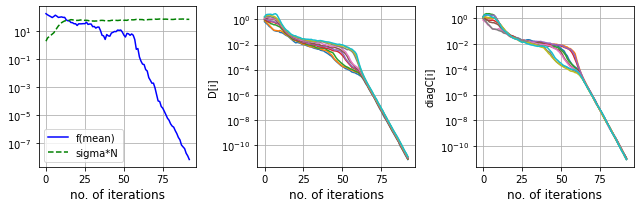

In [38]:
es = CMAES(func=rastrigin,            
           init_mean=-5.0 + 10.0*np.random.rand(10),
           init_sigma=0.1, 
           nsample=1000)             

maxiter = 100
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    D[i] = es.D
    diagC[i] = np.diag(es.C)
    if mean[i] < 1e-8:
        break

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()

## 考察

本節に示した５つの関数において，以下のパラメータを変えて実験し，それぞれの関数におけるCMA-ESの振る舞いを確認し，その原因を考察せよ．括弧の中の値は例であり，これに従う必要はない．

* 初期平均ベクトル init_mean (各問題の代表的な定義域内で一様分布)
* 初期ステップサイズ init_sigma (定義域の直径の$1/4$，$1/40$，$1/400$など)
* 集団サイズ nsample (推奨値，$N$, $10N$, $100N$など)

ここで，$N$は次元数であり，init_mean の次元数を変更すれば問題の次元数が変わる．

## リスタート戦略



上に見たように，目的関数が多峰性関数である場合，集団サイズや初期ステップサイズによって得られる局所解に差が生じる．しかし，これらについて適切な値を事前に知ることはできない．そこで，集団サイズや初期ステップサイズを変更しながらリスタートを繰り返すリスタート戦略がしばしば用いられる．

ここでは，IPOPリスタート戦略と呼ばれるものを紹介する．これは，リスタートの度に目的関数を倍増させていくアプローチである．初期平均ベクトルは定義域や初期化領域内で一様ランダムに生成し，初期ステップサイズはその直径の$1/4$などとする．ステップサイズは確率的に小さくすることも考えられるが，ここでは簡単のため固定とする．集団サイズは推奨値から始め，リスタート毎に倍増させる．

リスタート戦略を実装する場合，各リスタートの終了条件をうまく設計することが重要である．以下のコードでは，アルゴリズムの性質や一般的な使用方法，数値精度などを考慮して，汎用的に使える終了条件の一例を示すが，終了条件は実際に対象としている問題に依存して適切に設計されることが望ましい．

#### 終了条件の実装

In [35]:
from collections import deque
import math

class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, CMAES)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()
        
    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return np.max(self._cma.D) / np.min(self._cma.D) > 1e14

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * np.sqrt(self._cma.D[t]) * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''

#### 実行コード


10 100 180.31151074077619 164.49351673362017
20 200 93.94683229734778 93.94683229734778
30 300 119.9484601854213 63.485491267292126
40 400 95.98342884476638 63.485491267292126
50 500 104.59164108901967 63.485491267292126
60 600 74.82336479640749 63.485491267292126
70 700 100.46573359826476 63.485491267292126
80 800 105.57575007799105 61.57654707521373
90 900 126.1893755357435 61.57654707521373
100 1000 79.18994617490947 61.57654707521373
110 1100 97.05596738890137 61.57654707521373
120 1200 79.50233455482329 60.478099950832785
130 1300 90.36475346290271 60.478099950832785
140 1400 109.59889254057211 60.478099950832785
150 1500 99.3682470048369 60.478099950832785
160 1600 106.71973305415051 60.478099950832785
170 1700 74.33339982661411 60.478099950832785
180 1800 89.59795353129549 60.478099950832785
190 1900 89.60576797486266 60.478099950832785
200 2000 78.53237802293862 51.20834785134136
210 2100 59.92267879767841 51.20834785134136
220 2200 55.56207286603185 48.66712181347997
230 2300 

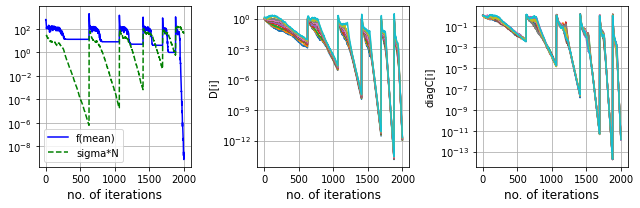

In [40]:
N = 10
lam = int(4 + 3 * np.log(N))
init_mean = -5.0 + (5.0 - (-5.0)) * np.random.randn(N)  
init_sigma = (5.0 - (-5.0)) / 4.0

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Logger
maxiter = 10000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

# Main loop
es = CMAES(func=rastrigin,            
           init_mean=init_mean,
           init_sigma=init_sigma, 
           nsample=lam) 
checker = Checker(es)

t = 0
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        es.sample()
        es.evaluate()
        es.update_param()
        mean[t] = es.func(es.mean)
        sigmaN[t] = es.sigma * es.N
        D[t] = es.D
        diagC[t] = np.diag(es.C)
        t += 1
        fbest = np.min(es.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        elif t >= maxiter:
            issatisfied, condition = True, 'maxiter'
        else:
            issatisfied, condition = checker()
        if es.t % 10 == 0:
            print(es.t, es.neval, fbest, fbestsofar)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += es.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = lam * 2 ** (restart + 1)
        init_mean = -5.0 + (5.0 - (-5.0)) * np.random.randn(N)  
        init_sigma = (5.0 - (-5.0)) / 4.0
        es = CMAES(func=rastrigin,            
                  init_mean=init_mean,
                  init_sigma=init_sigma, 
                  nsample=popsize) 
        checker = Checker(es)
        print("Restart with popsize: " + str(popsize))
    else:
        break

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()